In [1]:
import numpy as np
import math
import random
import time
from gurobipy import*
from gurobipy import GRB
import matplotlib.pyplot as plt
import pandas as pd

## Función para generación aleatoria de hipergrafos

In [2]:
def rand_hgraf(n,m,d):
    E = np.random.randint(2,d+1,size=(m))
    M = np.arange(m)
    N = np.arange(n)
    A = np.zeros((n,m))
    
    for j in M:
        t = 0
        while t < E[j]:
            s = int(np.random.choice(N,size=1))
            A[s,j] = 1
            t = np.sum(A[:,j])
    return A

In [3]:
#Tamaño promedio de las hiperaristas
def prom(A):
    m = A.shape[1]
    P = []
    for y in range(m):
        P.append(sum(A[:,y]))
    p = np.average(P)
    return p

#Tamaño máximo de las hiperaristas
def tamax(A):
    S = np.sum(A,axis=0)
    m = int(np.max(S))
    return m

#Vértices cubiertos por hiperaristas
def vert_cover(A,h):
    n = A.shape[0]
    S= np.zeros(n)
    for j in h:
        S += A[:,j]
    vc = np.where(S!=0)[0]
    return len(vc)

def union(A,s):
    U = np.sum(A[:,s],axis=1)
    u = np.where(U!=0)[0]
    return u

#Vértices en la interesección de las hiperaristas
def inter(A,e1,e2):
    I = A[:,e1]+A[:,e2]
    i = np.where(I>1)[0]
    return i

## Funciones para desigualdades válidas

In [4]:
#Hiperaristas tipo hoja
def hoja(A):
    n = A.shape[0]
    S = np.sum(A,axis=1)
    h = []
    for i in range(n):
        if S[i]==1:
            j = np.where(A[i,:]==1)[0][0]
            h.append(j)
    return h

#Hiperaristas contenidas
def cont(A):
    m = A.shape[1]   #número de hiperaristas
    tmax = tamax(A)
    h = {}
    for t in range(2,tmax+1):
        E = []
        for j in range(m):
            if sum(A[:,j])==t:
                E.append(j)
        h.update({t: E})
    C = {}
    for c_out in range(tmax,2,-1):
        for eo in h[c_out]:
            L = []
            for c_in in range(c_out-1,1,-1):
                for ei in h[c_in]:
                    d = A[:,ei]+A[:,eo]
                    s = len(np.where(d==2)[0])
                    if s == c_in:
                        L.append(ei)
            if len(L)>0:
                C.update({eo:L})
    return C

## Formulación $\mathcal{F}2$

In [5]:
def F2(A,W,K,alph):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.9)
    modelo.addConstrs(quicksum(x[i,k] for i in N) >= alph for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    
    modelo.update()
    modelo.optimize()
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,nods,g

## Formulación $\mathcal{F}2$ con planos cortantes

In [6]:
#Tipo hoja
def F2_pc1(A,W,K,alph):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.9)
    modelo.addConstrs(quicksum(x[i,k] for i in N) >= alph for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    #Hiperaristas tipo hoja
    for h in hoja(A):
        modelo.addConstr(quicksum(y[h,k] for k in C) == 1)
        modelo._cbCuts+=1
    modelo.update()
    modelo.optimize()
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [7]:
#Eliminacion de simetrias
def F2_pc2(A,W,K,alph):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.9)
    modelo.addConstrs(quicksum(x[i,k] for i in N) >= alph for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    #Eliminación de simetrías
    for c in C:
        modelo.addConstr(quicksum(x[c,l] for l in range(c+1,K))==0)
        modelo._cbCuts+=1
    modelo.update()
    modelo.optimize()
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [8]:
#Hiperaristas contenidas
def F2_pc3(A,W,K,alph):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.9)
    modelo.addConstrs(quicksum(x[i,k] for i in N) >= alph for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    #Hiperaristas contenidas
    y_node = {(j,k): 0 for j in M for k in C}
    CONT = cont(A)
    def mycallback(modelo,where):
        count=0
        if where == GRB.Callback.MIPNODE:
            if modelo.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
                for k in C:
                    for j in M:
                        y_node[j,k] = modelo.cbGetNodeRel(y[j,k])
                for p in CONT.keys():
                    for q in CONT[p]:
                        ds = quicksum(y_node[p,k]+y_node[q,k] for k in C)
                        if  ds.getValue()>1:
                            modelo.cbCut(quicksum(y[p,k]+y[q,k] for k in C) <= 1)
                            modelo._cbCuts+=1
                        else:
                            pass
    modelo.update()
    modelo.optimize(mycallback)
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [9]:
def F2_pc23(A,W,K,alph):
    #Parámetros
    #A: matriz de incidencia del hipergrafo
    #W: vector de pesos de las hiperaristas
    #K: número de particionamiento
    #alph: tamaño mínimo de componente
    n = A.shape[0]   #Número de nodos
    m = A.shape[1]   #Número de hiperaristas
    #Listas de conjuntos para las variables
    N = np.arange(n)
    M = np.arange(m)
    C = np.arange(K)
    #Creación del modelo
    modelo=Model()
    modelo.Params.LogToConsole = 0
    modelo.Params.timeLimit = 1800
    modelo.Params.cuts = 0
    modelo._cbCuts = 0
    #creación de variables
    x = modelo.addVars(N,C,vtype=GRB.BINARY, name='x')
    y = modelo.addVars(M,C,vtype=GRB.BINARY, name='y')
    #Función objetivo
    obj = quicksum(W[j]*y[j,k] for j in M for k in C)
    modelo.setObjective(obj, GRB.MINIMIZE)
    #Restricciones
    #(3.2)
    modelo.addConstrs(quicksum(x[i,k] for k in C) == 1 for i in N)
    #(3.9)
    modelo.addConstrs(quicksum(x[i,k] for i in N) >= alph for k in C)
    #(3.4)
    modelo.addConstrs(x[i,k] <= quicksum(A[i,j]*y[j,k] for j in M) for k in C for i in N)
    #(3.5)
    modelo.addConstrs(quicksum(y[j,k] for k in C) <= 1 for j in M)
    #(3.6)
    modelo.addConstrs(quicksum(A[i,j]*x[i,k] for i in N) >= sum(A[:,j])*y[j,k] for j in M for k in C)
    #Eliminación de simetrías
    for c in C:
        modelo.addConstr(quicksum(x[c,l] for l in range(c+1,K))==0)
        modelo._cbCuts+=1
    #Hiperaristas contenidas
    y_node = {(j,k): 0 for j in M for k in C}
    CONT = cont(A)
    def mycallback(modelo,where):
        count=0
        if where == GRB.Callback.MIPNODE:
            if modelo.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
                for k in C:
                    for j in M:
                        y_node[j,k] = modelo.cbGetNodeRel(y[j,k])
                for p in CONT.keys():
                    for q in CONT[p]:
                        ds = quicksum(y_node[p,k]+y_node[q,k] for k in C)
                        if  ds.getValue()>1:
                            modelo.cbCut(quicksum(y[p,k]+y[q,k] for k in C) <= 1)
                            modelo._cbCuts+=1
                        else:
                            pass
    modelo.update()
    modelo.optimize(mycallback)
    
    #Recuperación de variables
    V = []
    E = []   
    
    if modelo.SolCount == 0:
        time_r = modelo.Runtime
        sol = None
        nods = None
        g = None
        return V,E,time_r,sol,nods,g
    else:        
        time_r = modelo.Runtime
        sol = modelo.ObjVal
        nods = modelo.NodeCount
        g = 100*modelo.MIPGap
    
        for k in C:
            X = []
            for i in N:
                if x[i,k].x != 0:
                    X.append(i)
            V.append(X)
            Y = []
            for j in M:
                if y[j,k].x != 0:
                    Y.append(j)
            E.append(Y)
    
    return V,E,time_r,sol,[nods,modelo._cbCuts],g

In [10]:
n = 45
m = 300
k = 3
tam = 10

A = rand_hgraf(n,m,tam)
W = np.random.randint(1,21,size=m)
X,E,tr,val,nods,gap = F2(A,W,k,int(0.85*n/k))

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-08-03


In [11]:
X

[[0, 4, 7, 14, 15, 17, 23, 25, 27, 31, 37, 40, 41, 42],
 [1, 2, 3, 6, 10, 12, 13, 16, 18, 21, 22, 26, 28, 29, 30, 32, 38, 43],
 [5, 8, 9, 11, 19, 20, 24, 33, 34, 35, 36, 39, 44]]

In [12]:
E

[[139, 197, 215], [12, 229, 252, 253, 263], [112, 163, 220]]

In [13]:
for x in E[0]:
    for y in E[1]:
        print(inter(A,x,y))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [14]:
vert_cover(A,E[0]),len(X[0])

(14, 14)

In [15]:
val

41.0

In [16]:
tr

40.96203422546387

In [17]:
nods

16077.0

In [18]:
X1,E1,tr1,val1,nods1,gap1 = F2_pc2(A,W,k,int(0.8*n/k))

In [19]:
X1

[[0, 4, 7, 14, 15, 17, 23, 25, 27, 31, 37, 40, 41, 42],
 [1, 2, 3, 6, 10, 12, 13, 16, 18, 21, 22, 26, 28, 29, 30, 32, 38, 43],
 [5, 8, 9, 11, 19, 20, 24, 33, 34, 35, 36, 39, 44]]

In [20]:
E1

[[139, 197, 215], [12, 229, 252, 253, 263], [112, 163, 220]]

In [21]:
val1

41.0

In [22]:
nods1

[14575.0, 3]

In [23]:
tr1

40.96351623535156

In [26]:
P = np.array([[45,100],
              [45,200],
              [45,500],
              [90,150],
              [90,500],
              [90,1000],
              [150,300],
              [150,800],
              [150,1500],
              [180,400],
              [180,1000],
              [180,2000]])

tam = {45:[2,5,10],
       90:[2,5,10,20],
       150:[2,5,10,20],
       180:[2,5,10,20]}
R = []

for p in P:
    for t in tam[p[0]]:
        n = p[0]
        m = p[1]
        K = 3
        alpha = int(0.8*n/k)
        sol =None
        tr=0
        i=0
        while sol==None and tr<1000:
            A = rand_hgraf(n,m,t)
            pr = prom(A)
            W = np.random.randint(1,21,size=m)
            print(p,t)
            if t==2 and m/n <3:
                V,E,tr,sol,nod,g = F2(A,W,K,alpha)
                V1,E1,tr1,sol1,nod1,g1 = F2_pc1(A,W,K,alpha)
                V2,E2,tr2,sol2,nod2,g2 = F2_pc2(A,W,K,alpha)
                V3,E3,tr3,sol3,nod3,g3 = None,None,None,None,None,None
                V23,E23,tr23,sol23,nod23,g23 = F2_pc23(A,W,K,alpha)
            else:
                V,E,tr,sol,nod,g = F2(A,W,K,alpha)
                V1,E1,tr1,sol1,nod1,g1 = None,None,None,None,None,None
                V2,E2,tr2,sol2,nod2,g2 = F2_pc2(A,W,K,alpha)
                V3,E3,tr3,sol3,nod3,g3 = F2_pc3(A,W,K,alpha)
                V23,E23,tr23,sol23,nod23,g23 = F2_pc23(A,W,K,alpha)
            i += 1
            if i >=10:
                break        
        Tr=[tr,tr1,tr2,tr3,tr23]
        S=[sol,sol1,sol2,sol3,sol23]
        Nd=[nod,nod1,nod2,nod3,nod23]
        G=[g,g1,g2,g3,g23]
        print(Tr,S)
        print(Nd)
        R.append([p,pr,t,alpha,Tr,S,Nd,G])

[ 45 100] 2
[0.014959335327148438, 0.010974884033203125, 0.010950088500976562, None, 0.04483222961425781] [197.0, 197.0, 197.0, None, 197.0]
[1.0, [1.0, 2], [1.0, 3], None, [1.0, 3]]
[ 45 100] 5
[0.24686431884765625, None, 0.38727569580078125, 0.5657234191894531, 0.6797981262207031] [60.0, None, 60.0, 60.0, 60.0]
[499.0, None, [1420.0, 3], [499.0, 2], [860.0, 6]]
[ 45 100] 10
[4.46290397644043, None, 4.285926818847656, 6.859106063842773, 5.28485107421875] [133.0, None, 133.0, 133.0, 133.0]
[3475.0, None, [2839.0, 3], [3467.0, 32], [2695.0, 30]]
[ 45 200] 2
[0.019971847534179688, None, 0.022914886474609375, 0.0189208984375, 0.021921157836914062] [103.0, None, 103.0, 103.0, 103.0]
[1.0, None, [1.0, 3], [1.0, 0], [1.0, 3]]
[ 45 200] 5
[1.0808677673339844, None, 1.407632827758789, 2.6984481811523438, 3.1624908447265625] [44.0, None, 44.0, 44.0, 44.0]
[1904.0, None, [3298.0, 3], [2365.0, 54], [3066.0, 25]]
[ 45 200] 10
[7.950143814086914, None, 7.147611618041992, 19.666057586669922, 12.4433

[ 180 2000] 10
[1800.0714645385742, None, 1800.0488834381104, 1814.6872520446777, 1801.623634338379] [108.0, None, 115.0, 99.0, 105.0]
[17393.0, None, [16304.0, 3], [14271.0, 505], [15020.0, 300]]
[ 180 2000] 20
[1800.1242141723633, None, 1800.0920009613037, 1800.154405593872, 1800.3259315490723] [191.0, None, 213.0, 148.0, 199.0]
[6175.0, None, [6671.0, 3], [5645.0, 327], [6197.0, 1093]]


In [35]:
Df = pd.DataFrame(columns=['Instancia','Prom','Tam. max','Alpha','Plano cortante','Valor Función Objetivo','GAP', 'Nodos','Tiempo [s]'],
                 index=np.arange(len(R)*5))

pc = ['Ninguno','Tipo hoja','Elim. simetrías','Hiperaristas contenidas','ES+CO']

for x in range(len(R)):
    for y in range(5):
        Df.at[5*x+y,'Instancia']=R[x][0]
        Df.at[5*x+y,'Prom']=R[x][1]
        Df.at[5*x+y,'Tam. max']=R[x][2]
        Df.at[5*x+y,'Alpha']=R[x][3]
        Df.at[5*x+y,'Plano cortante']=pc[y]
        Df.at[5*x+y,'Valor Función Objetivo']=R[x][5][y]
        Df.at[5*x+y,'GAP']=R[x][7][y]
        Df.at[5*x+y,'Nodos']=R[x][6][y]
        Df.at[5*x+y,'Tiempo [s]']=R[x][4][y]
Df[:50]

,Instancia,Prom,Tam. max,Alpha,Plano cortante,Valor Función Objetivo,GAP,Nodos,Tiempo [s]
0,"[45, 100]",2,2,12,Ninguno,197,0,1,0.0149593
1,"[45, 100]",2,2,12,Tipo hoja,197,0,"[1.0, 2]",0.0109749
2,"[45, 100]",2,2,12,Elim. simetrías,197,0,"[1.0, 3]",0.0109501
3,"[45, 100]",2,2,12,Hiperaristas contenidas,None,None,None,None
4,"[45, 100]",2,2,12,ES+CO,197,0,"[1.0, 3]",0.0448322
5,"[45, 100]",3.59,5,12,Ninguno,60,0,499,0.246864
6,"[45, 100]",3.59,5,12,Tipo hoja,None,None,None,None
7,"[45, 100]",3.59,5,12,Elim. simetrías,60,0,"[1420.0, 3]",0.387276
8,"[45, 100]",3.59,5,12,Hiperaristas contenidas,60,0,"[499.0, 2]",0.565723
9,"[45, 100]",3.59,5,12,ES+CO,60,0,"[860.0, 6]",0.679798


In [40]:
Df.to_excel('pruebas_F2.xlsx')

In [45]:
df = pd.read_excel('pruebas_F2.xlsx') 
INST = df['Instancia'].tolist()
Tiempo = df['Tiempo [s]'].tolist()
Plano = df['Plano cortante'].tolist()
GAP = df['GAP'].tolist()
TAM = df['Tam. max'].tolist()
P = list([[45,100],
          [45,200],
          [45,500],
          [90,150],
          [90,500],
          [90,1000],
          [150,300],
          [150,800],
          [150,1500],
          [180,400],
          [180,1000],
          [180,2000]])
pc = ['Ninguno','Tipo hoja','Elim. simetrías','Hiperaristas contenidas','ES+CO']

In [46]:
I = []
for x in P:
    if x[0] == 45:
        for y in [2,5,10]:
            I.append([x,y])
    elif x[0] == 90:
        for y in [2,5,10,20]:
            I.append([x,y])
    elif x[0] == 150:
        for y in [2,5,10,20]:
            I.append([x,y])
    elif x[0] == 180:
        for y in [2,5,10,20]:
            I.append([x,y])

In [47]:
T_tam2 = []
T_tam5  = []
T_tam10  = []
T_tam20  = []
G_tam2  = []
G_tam5  = []
G_tam10  = []
G_tam20  = []
com2=[]
com5=[]
com10=[]
com20=[]

for x in range(len(I)):
    tam = I[x][1]
    if tam==2:
        tiempo = [Tiempo[5*x+y] for y in range(5)]
        T_tam2.append(tiempo)
        g = [GAP[5*x+y] for y in range(5)]
        G_tam2.append(g)
        com2.append(str(I[x][0]))
    elif tam==5:
        tiempo = [Tiempo[5*x+y] for y in range(5)]
        T_tam5.append(tiempo)
        g = [GAP[5*x+y] for y in range(5)]
        G_tam5.append(g)
        com5.append(str(I[x][0]))
    elif tam==10:
        tiempo = [Tiempo[5*x+y] for y in range(5)]
        T_tam10.append(tiempo)
        g = [GAP[5*x+y] for y in range(5)]
        G_tam10.append(g)
        com10.append(str(I[x][0]))
    elif tam==20:
        tiempo = [Tiempo[5*x+y] for y in range(5)]
        T_tam20.append(tiempo)
        g = [GAP[5*x+y] for y in range(5)]
        G_tam20.append(g)
        com20.append(str(I[x][0]))

<ipython-input-48-c139aae8c700>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs1[0].set_xticklabels(com2,rotation=90)
<ipython-input-48-c139aae8c700>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs1[1].set_xticklabels(com2,rotation=90)
<ipython-input-48-c139aae8c700>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs2[0].set_xticklabels(com5,rotation=90)
<ipython-input-48-c139aae8c700>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs2[1].set_xticklabels(com5,rotation=90)
<ipython-input-48-c139aae8c700>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs3[0].set_xticklabels(com10,rotation=90)
<ipython-input-48-c139aae8c700>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs3[1].set_xticklabels(com10,rotation=90)
<ipython-input-48-c139aae8c700>:103: UserWarning: FixedFormatter sho

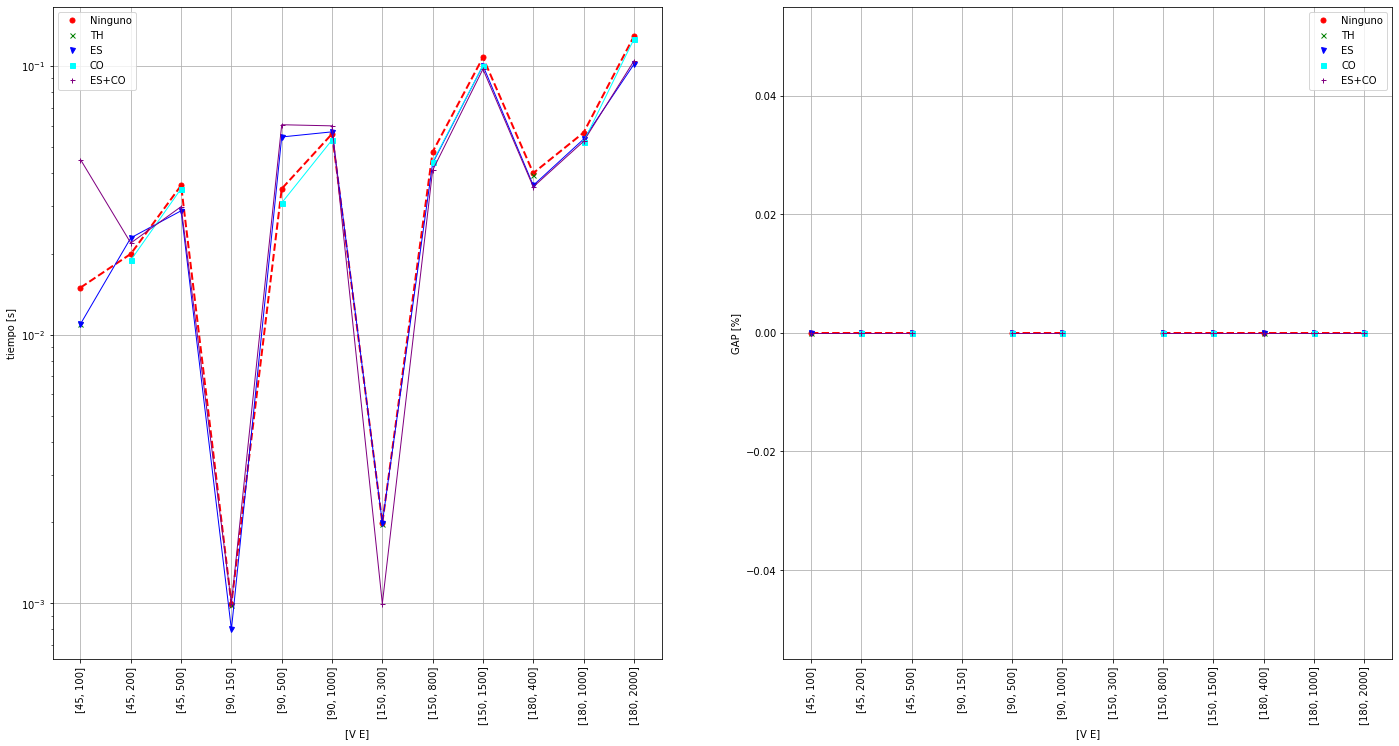

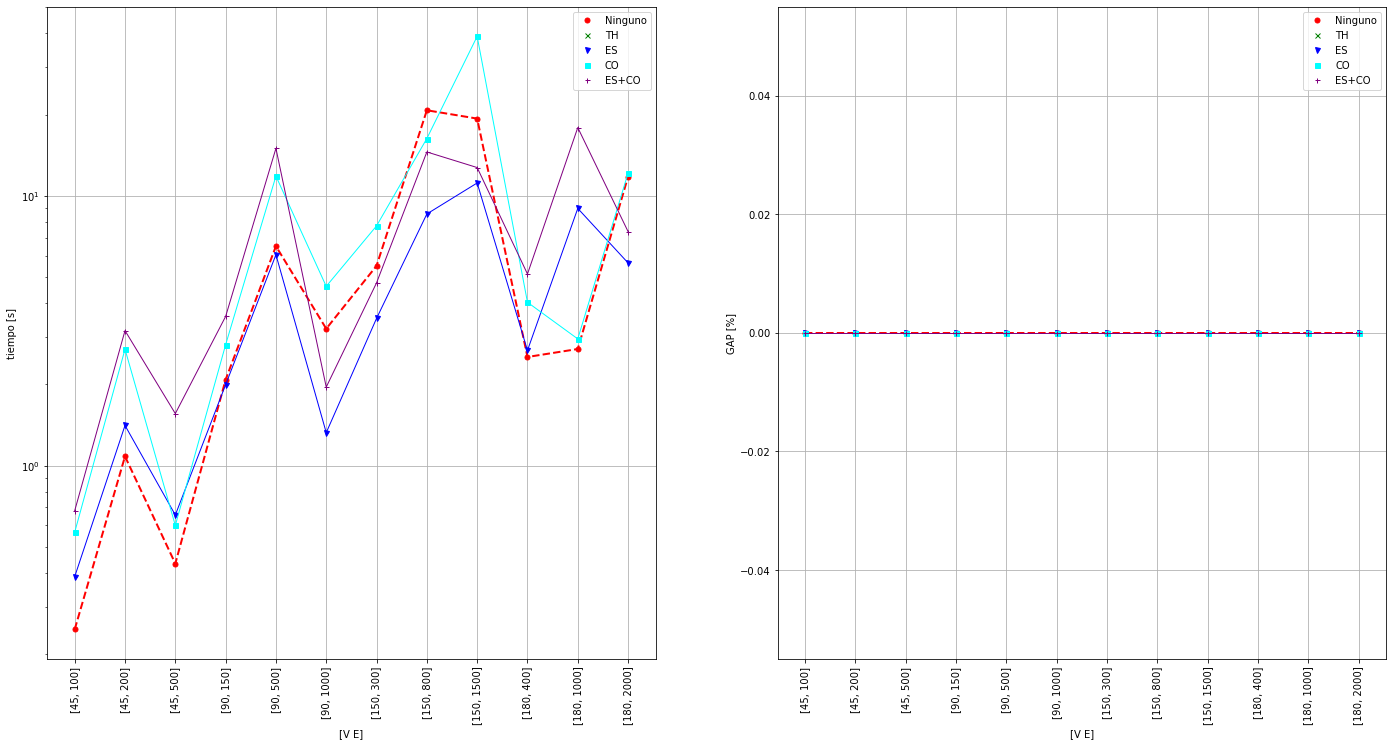

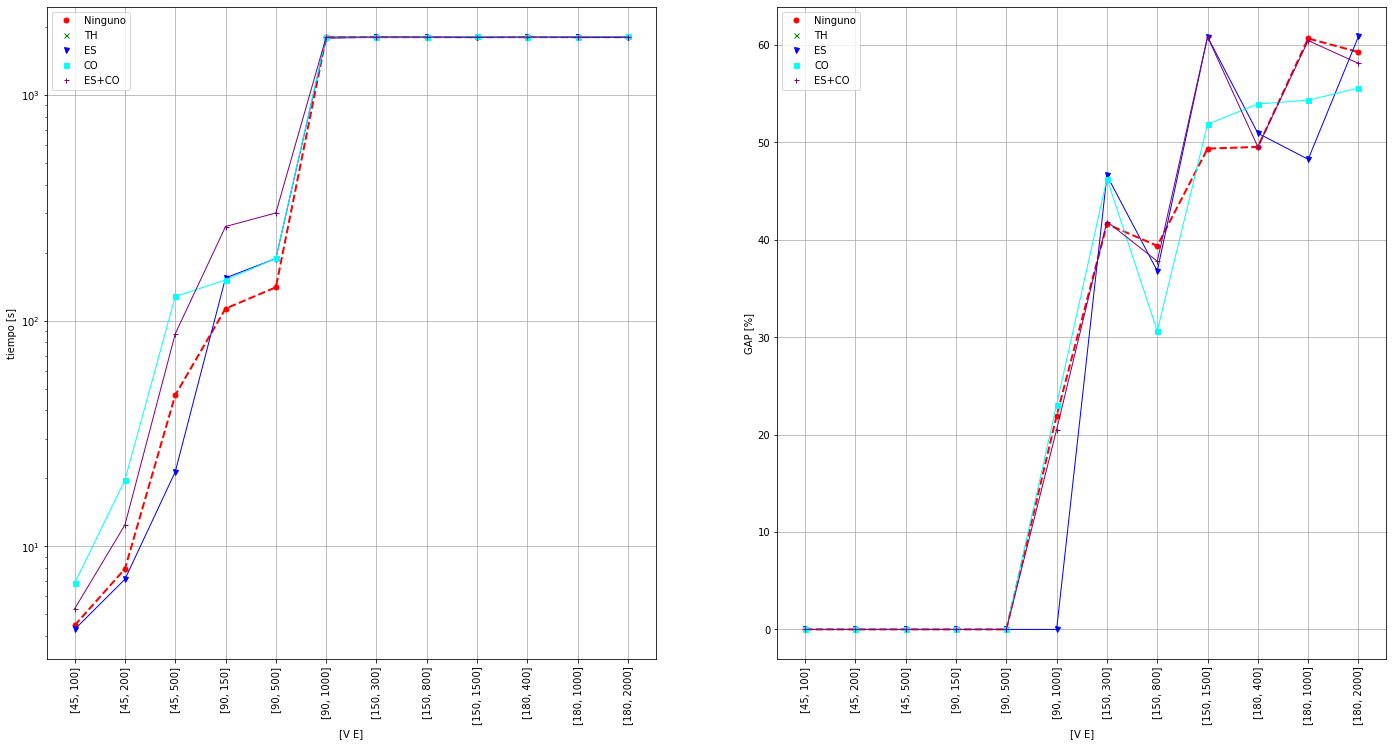

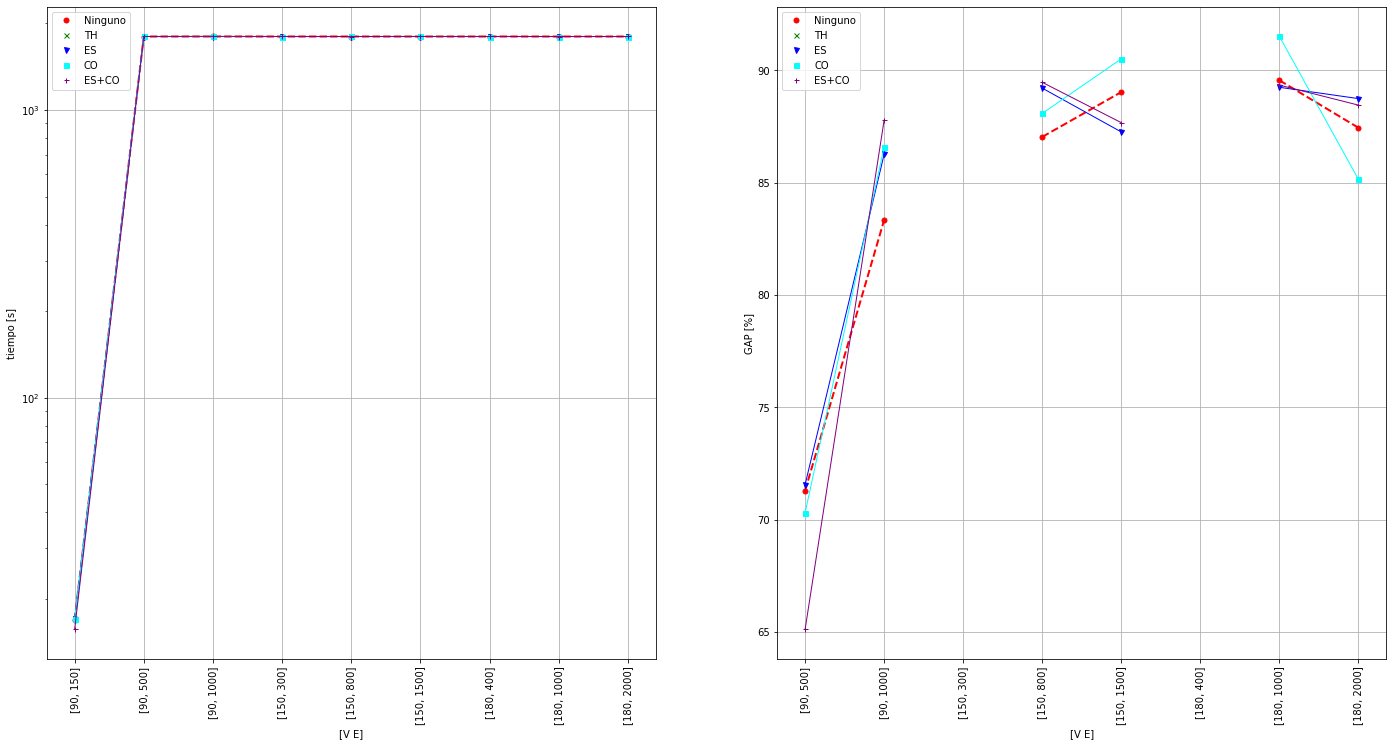

In [48]:
fig1 ,axs1 = plt.subplots(1,2,figsize=(24,12)) #tam2
fig2 ,axs2 = plt.subplots(1,2,figsize=(24,12)) #tam5
fig3 ,axs3 = plt.subplots(1,2,figsize=(24,12)) #tam10
fig4 ,axs4 = plt.subplots(1,2,figsize=(24,12)) #tam20

import matplotlib.lines as mlines

line_parm = {
            0:{'color':'red', 'marker':'o', 'linestyle':'dashed','linewidth':2, 'markersize':5, 'label':'Ninguno'},
            1:{'color':'green', 'marker':'x', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'TH'},
            2:{'color':'blue', 'marker':'v', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'ES'},
            3:{'color':'cyan', 'marker':'s', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'CO'},
            4:{'color':'purple', 'marker':'+', 'linestyle':'-', 'linewidth':1,'markersize':5, 'label':'ES+CO'},
}
mod = [
    mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=5, label='Ninguno'),
     mlines.Line2D([], [], color='green', marker='x', linestyle='None',
                        markersize=5, label='TH'),
     mlines.Line2D([], [], color='blue', marker='v', linestyle='None',
                        markersize=5, label='ES'),
     mlines.Line2D([], [], color='cyan', marker='s', linestyle='None',
                        markersize=5, label='CO'),
     mlines.Line2D([], [], color='purple', marker='+', linestyle='None',
                        markersize=5, label='ES+CO')]

#TAM2
axs1[0].set_xticklabels(com2,rotation=90)
axs1[0].set_xlabel('[V E]')
axs1[0].set_yscale('log')
axs1[0].set_ylabel('tiempo [s]')
axs1[0].plot(com2,[x[0] for x in T_tam2],**line_parm[0])
axs1[0].plot(com2,[x[1] for x in T_tam2],**line_parm[1])
axs1[0].plot(com2,[x[2] for x in T_tam2],**line_parm[2])
axs1[0].plot(com2,[x[3] for x in T_tam2],**line_parm[3])
axs1[0].plot(com2,[x[4] for x in T_tam2],**line_parm[4])
axs1[0].legend(handles=mod)
axs1[0].grid(True)
axs1[1].set_xticklabels(com2,rotation=90)
axs1[1].set_xlabel('[V E]')
axs1[1].set_ylabel('GAP [%]')
axs1[1].plot(com2,[x[0] for x in G_tam2],**line_parm[0])
axs1[1].plot(com2,[x[1] for x in G_tam2],**line_parm[1])
axs1[1].plot(com2,[x[2] for x in G_tam2],**line_parm[2])
axs1[1].plot(com2,[x[3] for x in G_tam2],**line_parm[3])
axs1[1].plot(com2,[x[4] for x in G_tam2],**line_parm[4])
axs1[1].legend(handles=mod)
axs1[1].grid(True)
#fig1.suptitle('$|e_{max}|=2$',fontsize=36)
fig1.savefig('F2_tam2.jpg',bbox_inches='tight',dpi=300)

#TAM5
axs2[0].set_xticklabels(com5,rotation=90)
axs2[0].set_xlabel('[V E]')
axs2[0].set_yscale('log')
axs2[0].set_ylabel('tiempo [s]')
axs2[0].plot(com5,[x[0] for x in T_tam5],**line_parm[0])
axs2[0].plot(com5,[x[1] for x in T_tam5],**line_parm[1])
axs2[0].plot(com5,[x[2] for x in T_tam5],**line_parm[2])
axs2[0].plot(com5,[x[3] for x in T_tam5],**line_parm[3])
axs2[0].plot(com5,[x[4] for x in T_tam5],**line_parm[4])
axs2[0].legend(handles=mod)
axs2[0].grid(True)
axs2[1].set_xticklabels(com5,rotation=90)
axs2[1].set_xlabel('[V E]')
axs2[1].set_ylabel('GAP [%]')
axs2[1].plot(com5,[x[0] for x in G_tam5],**line_parm[0])
axs2[1].plot(com5,[x[1] for x in G_tam5],**line_parm[1])
axs2[1].plot(com5,[x[2] for x in G_tam5],**line_parm[2])
axs2[1].plot(com5,[x[3] for x in G_tam5],**line_parm[3])
axs2[1].plot(com5,[x[4] for x in G_tam5],**line_parm[4])
axs2[1].legend(handles=mod)
axs2[1].grid(True)
#fig2.suptitle('$|e_{max}|=5$',fontsize=36)
fig2.savefig('F2_tam5.jpg',bbox_inches='tight',dpi=300)

#TAM10
axs3[0].set_xticklabels(com10,rotation=90)
axs3[0].set_xlabel('[V E]')
axs3[0].set_yscale('log')
axs3[0].set_ylabel('tiempo [s]')
axs3[0].plot(com10,[x[0] for x in T_tam10],**line_parm[0])
axs3[0].plot(com10,[x[1] for x in T_tam10],**line_parm[1])
axs3[0].plot(com10,[x[2] for x in T_tam10],**line_parm[2])
axs3[0].plot(com10,[x[3] for x in T_tam10],**line_parm[3])
axs3[0].plot(com10,[x[4] for x in T_tam10],**line_parm[4])
axs3[0].legend(handles=mod)
axs3[0].grid(True)
axs3[1].set_xticklabels(com10,rotation=90)
axs3[1].set_xlabel('[V E]')
axs3[1].set_ylabel('GAP [%]')
axs3[1].plot(com10,[x[0] for x in G_tam10],**line_parm[0])
axs3[1].plot(com10,[x[1] for x in G_tam10],**line_parm[1])
axs3[1].plot(com10,[x[2] for x in G_tam10],**line_parm[2])
axs3[1].plot(com10,[x[3] for x in G_tam10],**line_parm[3])
axs3[1].plot(com10,[x[4] for x in G_tam10],**line_parm[4])
axs3[1].legend(handles=mod)
axs3[1].grid(True)
#fig3.suptitle('$|e_{max}|=10$',fontsize=36)
fig3.savefig('F2_tam10.jpg',bbox_inches='tight',dpi=300)

#TAM20
axs4[0].set_xticklabels(com20,rotation=90)
axs4[0].set_xlabel('[V E]')
axs4[0].set_yscale('log')
axs4[0].set_ylabel('tiempo [s]')
axs4[0].plot(com20,[x[0] for x in T_tam20],**line_parm[0])
axs4[0].plot(com20,[x[1] for x in T_tam20],**line_parm[1])
axs4[0].plot(com20,[x[2] for x in T_tam20],**line_parm[2])
axs4[0].plot(com20,[x[3] for x in T_tam20],**line_parm[3])
axs4[0].plot(com20,[x[4] for x in T_tam20],**line_parm[4])
axs4[0].legend(handles=mod)
axs4[0].grid(True)
axs4[1].set_xticklabels(com20,rotation=90)
axs4[1].set_xlabel('[V E]')
axs4[1].set_ylabel('GAP [%]')
axs4[1].plot(com20,[x[0] for x in G_tam20],**line_parm[0])
axs4[1].plot(com20,[x[1] for x in G_tam20],**line_parm[1])
axs4[1].plot(com20,[x[2] for x in G_tam20],**line_parm[2])
axs4[1].plot(com20,[x[3] for x in G_tam20],**line_parm[3])
axs4[1].plot(com20,[x[4] for x in G_tam20],**line_parm[4])
axs4[1].legend(handles=mod)
axs4[1].grid(True)
#fig4.suptitle('$|e_{max}|=20$',fontsize=36)
fig4.savefig('F2_tam20.jpg',bbox_inches='tight',dpi=300)
plt.show()